Dataset Description

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

File and Data Field Descriptions

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage.

Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, classification_report

from sklearn.feature_selection import SelectFromModel, GenericUnivariateSelect, mutual_info_classif

## EDA

In [40]:
df = pd.read_csv('train.csv')

In [41]:
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [43]:
df['Transported'] = df['Transported'].astype(int)

In [44]:
obj_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin']
num_features = ['Age', 'RoomService', 'FoodCourt',  'ShoppingMall', 'Spa', 'VRDeck']

In [45]:
for feat in obj_features:
    print(f'{"="*20} {feat} {"="*20}')
    print(df[feat].value_counts(normalize=True))
    print('*'*50)

==================== HomePlanet ====================
Earth     0.541922
Europa    0.250942
Mars      0.207136
Name: HomePlanet, dtype: float64
**************************************************
==================== CryoSleep ====================
False    0.641694
True     0.358306
Name: CryoSleep, dtype: float64
**************************************************
==================== Destination ====================
TRAPPIST-1e      0.694983
55 Cancri e      0.211491
PSO J318.5-22    0.093526
Name: Destination, dtype: float64
**************************************************
==================== VIP ====================
False    0.976561
True     0.023439
Name: VIP, dtype: float64
**************************************************
==================== Cabin ====================
G/734/S     0.000942
G/109/P     0.000824
B/201/P     0.000824
G/1368/P    0.000824
G/981/S     0.000824
              ...   
G/556/P     0.000118
E/231/S     0.000118
G/545/S     0.000118
G/543/S     0.000118
F

In [46]:
obj_features.remove('Cabin')

In [47]:
plt.figure(figsize=(10, 8));


<Figure size 720x576 with 0 Axes>

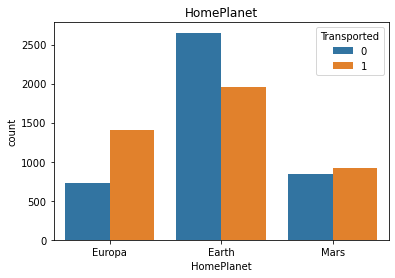

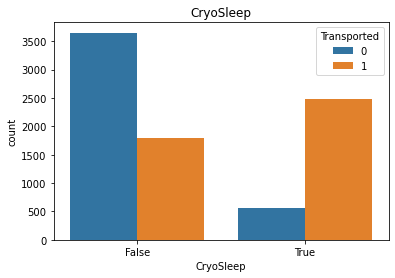

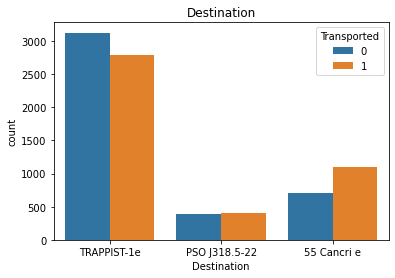

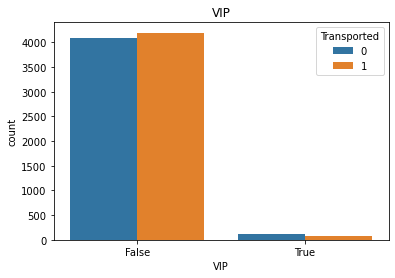

In [48]:
for obj_f in obj_features:
    sns.countplot(x=obj_f, hue='Transported', data=df)
    plt.title(obj_f)
    plt.legend(title='Transported', loc='upper right')

    plt.show()

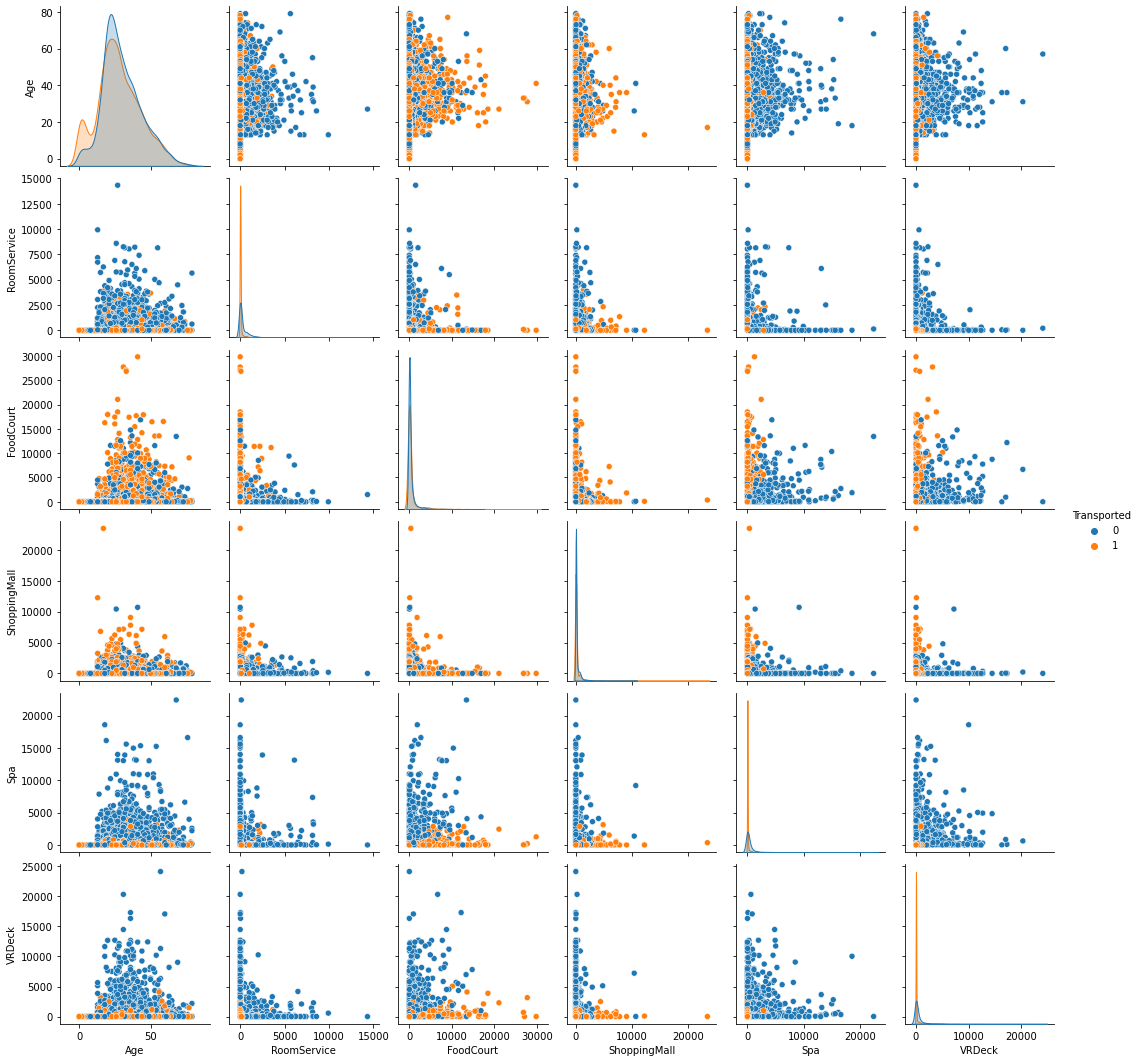

In [49]:
sns.pairplot(df[num_features + ["Transported"]], hue="Transported")

#### На первый взгляд, кто много тусил, тратил деньги во всяких местах, а не спал в капсуле, тот реже долетал. Может умирали от старости, ведь лететь далеко.

In [50]:
df['group'] = df['PassengerId'].apply(lambda x: x[-2:])


In [51]:
df['group'].value_counts()

01    6217
02    1412
03     571
04     231
05     128
06      75
07      46
08      13
Name: group, dtype: int64

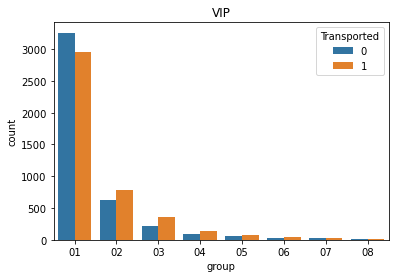

In [52]:
sns.countplot(x='group', hue='Transported', data=df)
plt.title(obj_f)
plt.legend(title='Transported', loc='upper right')

plt.show()

In [53]:
df.loc[df["Cabin"].isnull(), "Cabin"] = '-1/-1/-1'

In [54]:
df[['cab1','cab2','cab3']] = pd.DataFrame(df['Cabin'].str.split('/').tolist(),
                                 columns = ['cab1','cab2','cab3'])

In [55]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group,cab1,cab2,cab3
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,01,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,01,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,01,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,01,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,01,E,608,S


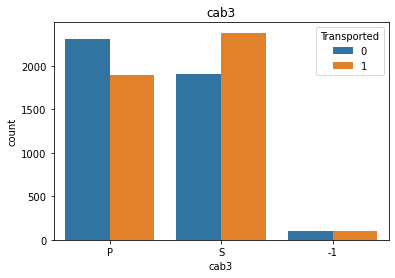

In [56]:
sns.countplot(x='cab3', hue='Transported', data=df)
plt.title('cab3')
plt.legend(title='Transported', loc='upper right')

plt.show()

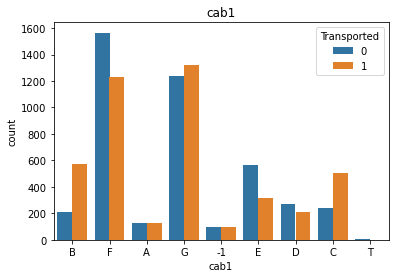

In [57]:
sns.countplot(x='cab1', hue='Transported', data=df)
plt.title('cab1')
plt.legend(title='Transported', loc='upper right')

plt.show()

### BASELINE

In [327]:
def some_prepare(X):
    X['group'] = X['PassengerId'].apply(lambda x: x[-2:])
    X.loc[X["Cabin"].isnull(), "Cabin"] = '-1/-1/-1'
    X[['cab1','cab2','cab3']] = pd.DataFrame(X['Cabin'].str.split('/').tolist(),
                                 columns = ['cab1','cab2','cab3'])
    X['CryoSleep'] = X['CryoSleep'].replace({True: 1, False : 0})
    X['VIP'] = X['VIP'].replace({True: 1, False : 0})
    
    num_features = ['Age', 'RoomService', 'FoodCourt',  'ShoppingMall', 'Spa', 'VRDeck']
    return X

In [328]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [329]:
df = pd.read_csv('train.csv')

In [330]:
df['Transported'] = df['Transported'].astype(int)

In [331]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('Transported', axis=1), df['Transported'], random_state=7)

In [332]:
X_train = some_prepare(X_train)

In [333]:
X_valid = some_prepare(X_valid)

In [334]:
obj_features = ['HomePlanet',  'Destination', 'cab1','cab3']
bin_features = ['CryoSleep', 'VIP']
num_features = ['Age', 'RoomService', 'FoodCourt','cab2',  'ShoppingMall', 'Spa', 'VRDeck']

In [335]:
all_feats = obj_features + num_features + bin_features

In [336]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=all_feats),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(num_features),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(obj_features),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(bin_features),
            SimpleImputer(strategy="most_frequent")
            
        ))
    ])
)

In [337]:
log_reg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=7)
)

In [338]:
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['HomePlanet',
                                                          'Destination', 'cab1',
                                                          'cab3', 'Age',
                                                          'RoomService',
                                                          'FoodCourt', 'cab2',
                                                          'ShoppingMall', 'Spa',
                                                          'VRDeck', 'CryoSleep',
                                                          'VIP'])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['Age',
                                                                                                           'R...
                                                                                                           'cab3'])),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore'))])),
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['CryoSleep',
                                                                                                           'VIP'])),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(strategy='most_frequent'))]))]))])),
                ('logisticregression', LogisticRegression(random_state=7))])

In [339]:
y_pred = log_reg_pipe.predict(X_valid)

In [340]:
accuracy_score(y_valid, y_pred)

0.7999080036798528

### 2 Добавим полином

In [341]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=all_feats),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(num_features),
            SimpleImputer(strategy="mean"),
            PolynomialFeatures(degree=2),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(obj_features),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(bin_features),
            SimpleImputer(strategy="most_frequent")
            
        ))
    ])
)

In [342]:
log_reg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=7)
)

In [343]:
log_reg_pipe.fit(X_train, y_train)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['HomePlanet',
                                                          'Destination', 'cab1',
                                                          'cab3', 'Age',
                                                          'RoomService',
                                                          'FoodCourt', 'cab2',
                                                          'ShoppingMall', 'Spa',
                                                          'VRDeck', 'CryoSleep',
                                                          'VIP'])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['Age',
                                                                                                           'R...
                                                                                                           'cab3'])),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore'))])),
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['CryoSleep',
                                                                                                           'VIP'])),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(strategy='most_frequent'))]))]))])),
                ('logisticregression', LogisticRegression(random_state=7))])

In [344]:
y_pred = log_reg_pipe.predict(X_valid)

In [345]:
accuracy_score(y_valid, y_pred)

0.8031278748850046

### 3 другая модель

In [346]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=all_feats),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(num_features),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(obj_features),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(bin_features),
            SimpleImputer(strategy="most_frequent")
            
        ))
    ])
)

In [347]:
log_reg_pipe = make_pipeline(
    f_prep_pipeline,
    XGBClassifier(random_state=7, eta=0.1, max_depth=5)
)

In [348]:
log_reg_pipe.fit(X_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['HomePlanet',
                                                          'Destination', 'cab1',
                                                          'cab3', 'Age',
                                                          'RoomService',
                                                          'FoodCourt', 'cab2',
                                                          'ShoppingMall', 'Spa',
                                                          'VRDeck', 'CryoSleep',
                                                          'VIP'])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['Age',
                                                                                                           'R...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=7, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [349]:
y_pred = log_reg_pipe.predict(X_valid)

In [350]:
accuracy_score(y_valid, y_pred)

0.8118675252989881